In [1]:
import os
import pandas as pd
import numpy as np
import time
import re
import codecs
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import datetime
from scipy.spatial.distance import cosine

nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tommi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Import data

Please change the directories based on your local machine

In [15]:
#Please change directories based on your local machine
base_directory = r'C:\Users\tommi\Documents\Columbia 2020 Fall\Capstone\peace-speech-project-master\peace-speech-project-master\data\sample'

conflict = pd.read_excel(r'C:\Users\tommi\Documents\Columbia 2020 Fall\Capstone\peace-speech-project-master/enh_conflict_lexicon.xlsx')
peace = pd.read_excel(r'C:\Users\tommi\Documents\Columbia 2020 Fall\Capstone\peace-speech-project-master/enh_peace_lexicon.xlsx')
resilence = pd.read_excel(r'C:\Users\tommi\Documents\Columbia 2020 Fall\Capstone\peace-speech-project-master/enh_resilience_lexicon.xlsx')

In [11]:
#Read Files from local machine
start_time = datetime.datetime.now()
for entry_country in os.scandir(base_directory):
    df_dict_country = {"id": [], "title": [], "publisher": [], "article_text":[],"url":[], "path":[]}
    for entry_publisher in os.scandir(entry_country.path):
        for entry_year in os.scandir(entry_publisher.path):
            for entry_final in os.scandir(entry_year.path):
                try:
                    with open(entry_final, "r") as f:
                        article_id = f.readline().strip()
                        article_title = f.readline().strip()
                        publisher = f.readline().strip()
                        url = f.readline()
                        f.readline()
                        article_text = f.readline().strip()
                        df_dict_country['url'].append(url)
                        df_dict_country['id'].append(article_id)
                        df_dict_country['title'].append(article_title)
                        df_dict_country['publisher'].append(publisher)
                        df_dict_country['article_text'].append(article_text)
                        df_dict_country['path'].append(entry_final.name)
                except:
                    pass
        #break
    break
end_time = datetime.datetime.now()

In [24]:
#time taken for reading one country
end_time - start_time

datetime.timedelta(seconds=635, microseconds=160094)

In [12]:
df_dict_country = pd.DataFrame.from_dict(df_dict_country)

In [13]:
df_dict_country

,id,title,publisher,article_text,url,path
0,15732244,Gable Tostee dumped by 'emotional starved' gir...,9Honey,<h> Gable Tostee dumped by ' emotional starved...,http://honey.nine.com.au/2016/12/05/06/22/gabl...,15732244_AU_04-12-16.txt
1,15849634,Food news bites: from a Melbourne icon popping...,9Honey,<h> News bites : from a Melbourne icon popping...,http://kitchen.nine.com.au/2016/12/11/21/45/fo...,15849634_AU_11-12-16.txt
2,15855997,Made with love: Kaum celebrates the best of Ba...,9Honey,<h> Made with love : Kaum celebrates the best ...,http://elsewhere.nine.com.au/2016/12/12/07/29/...,15855997_AU_11-12-16.txt
3,15895978,This kid is going viral for his perfect review...,9Honey,<h> This kid is going viral for his perfect re...,http://kitchen.nine.com.au/2016/12/14/12/41/th...,15895978_AU_13-12-16.txt
4,16005675,Meghan Markle targeted in cruel topless photo ...,9Honey,<h> Meghan Markle targeted in cruel topless ph...,http://honey.nine.com.au/2016/12/21/06/11/megh...,16005675_AU_20-12-16.txt
...,...,...,...,...,...,...
109982,50539343,"Mutual understanding helps Finch, Khawaja",Yahoo7 Sport,"<h> Mutual understanding helps Finch , Khawaja...",https://au.sports.yahoo.com/mutual-understandi...,50539343_AU_25-03-19.txt
109983,50551208,Gyan hoping to be in shape for Ghana's Africa ...,Yahoo7 Sport,<h> Gyan hoping to be in shape for Ghana 's Af...,https://au.sports.yahoo.com/gyan-hoping-shape-...,50551208_AU_29-03-19.txt
109984,50558421,No anxiety over Almiron's lack of Newcastle go...,Yahoo7 Sport,<h> No anxiety over Almiron 's lack of Newcast...,https://au.sports.yahoo.com/no-anxiety-over-al...,50558421_AU_01-04-19.txt
109985,50566157,'He could fit into any top team' - De Ligt bac...,Yahoo7 Sport,<h> ' He could fit into any top team ' - De Li...,https://au.sports.yahoo.com/apos-could-fit-top...,50566157_AU_04-04-19.txt


## Word Frequency Analysis with visualization

create_vocab_dict: creates the vocab dictionary based on the lexicons from *peace*, *conflict*, *resilence*; have only counted lexicons less than 5 words (4-gram max)

word_freq: uses Countvectorizer to creates the dictionary with word counts {str(word):int(count)}

plot_n_most_common_words: using the dictionary with word counts, output the graph with given integer n.

In [16]:
conflict['label'] = 'conflict'
peace['label'] = 'peace'
resilence['label'] = 'resilence'
conflict = conflict.loc[:,['Term', 'label']]
peace['Term'] = peace['academic freedom']
peace = peace.loc[:,['Term', 'label']]
resilence = resilence.loc[:,['Term', 'label']]

vocab_df = conflict.copy()
vocab_df = vocab_df.append(peace)
vocab_df = vocab_df.append(resilence)
vocab_df.index = np.arange(0, len(vocab_df))

In [36]:
#Create dictionary for the vocab in CountVectorizer
def create_vocab_dict(vocab_df):
    vocabs = vocab_df.Term.str.lower()
    vocabs = list(set(vocabs))
    vocab_dictionary = {}
    idx = 0
    for vocab in vocabs:
        voc_len = len(word_tokenize(vocab))
        if voc_len < 5:
            vocab_dictionary[vocab] = idx
            idx += 1
    return vocab_dictionary

In [29]:
#Using Countvectorizer to count all the n-grams
def word_freq(df, vocab_dictionary):
    count_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,4), vocabulary= vocab_dictionary)
    count_data = count_vectorizer.fit_transform(df.text)
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts += t.toarray()[0]
  
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key = lambda x:x[1], reverse = True)

    return count_dict

In [31]:
def plot_n_most_common_words(count_dict, n):
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:n]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title= str(n) + ' most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

In [37]:
vocab_dictionary = create_vocab_dict(vocab_df)

### Create Word Freq

If you have used different columns for cleaned_text, please add another column or change the column name to text.

In [39]:
#df_dict_country['text'] = df_dict_country['article_text']
start_time = datetime.datetime.now()
count_dict= word_freq(df_dict_country, vocab_dictionary)
end_time = datetime.datetime.now()

In [40]:
#Time taken for creating count_dict
end_time - start_time

datetime.timedelta(seconds=96, microseconds=711588)

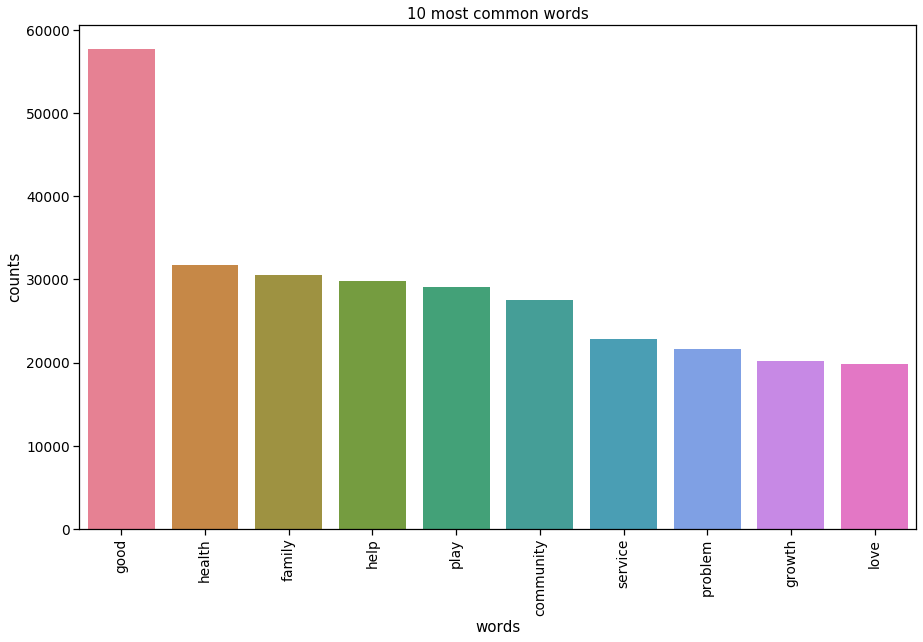

In [41]:
plot_n_most_common_words(count_dict, 10)